In [1]:
sample = "EB_FO864_RH"
#template = "cCARLIN"
data_path = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Processed/amplicon/fastq/"
output_dir = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/code/output/"
ref_dir ='/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Analysis/EB/FO864/SC/RH/Transcriptome/filtered_barcodes_umi_mt.txt'
#CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg="sc10xV3" # ['sc10xV3',  'scCamellia']
coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
#seq_3prime_upper_N=15
#seq_5prime_upper_N=None

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from mosaiclineage import DARLIN as car
from mosaiclineage import larry

/home/zhoujiaqi/miniconda2/envs/darlin/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
import importlib
importlib.reload(car)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
%matplotlib inline

# Single-cell CARLIN pipeline for 10x data

In [4]:
ref_name=cfg
df_ref_BC=pd.read_csv(f'{ref_dir}',
                      sep='\t',header=None,names=['CB'])

In [5]:
df_ref_BC

,CB
0,AAACCTGCAACGATCT
1,AAACCTGCAGACACTT
2,AAACCTGCATCGATGT
3,AAACCTGGTAGGGTAC
4,AAACCTGGTCAGAAGC
...,...
5256,TTTGTCAAGGTGCAAC
5257,TTTGTCACACCTGGTG
5258,TTTGTCACACTTCGAA
5259,TTTGTCATCCCAACGG


In [6]:
%%time
## load sequences
df_raw_reads=car.CARLIN_raw_reads(data_path+sample,sample,protocol=cfg)

CPU times: user 21.4 s, sys: 366 ms, total: 21.8 s
Wall time: 21.8 s


In [7]:
df_raw_reads

,cell_bc,cell_bc_quality_mean,cell_bc_quality_min,library,cell_id,umi,umi_quality_mean,umi_quality_min,umi_id,clone_id,clone_id_quality_mean,clone_id_quality_min
0,TCAGCAAGTGTCTGAT,32.2500,18,EB_FO864_RH,EB_FO864_RH_TCAGCAAGTGTCTGAT,GGCTCCTGTATT,36.416667,32,TCAGCAAGTGTCTGAT_GGCTCCTGTATT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,24.348571,12
1,TACGGATGTTATCACG,35.0000,32,EB_FO864_RH,EB_FO864_RH_TACGGATGTTATCACG,CTAGTTCTCGTT,38.250000,38,TACGGATGTTATCACG_CTAGTTCTCGTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGG...,25.714286,12
2,CGCTGGACACGCTTTC,34.1250,18,EB_FO864_RH,EB_FO864_RH_CGCTGGACACGCTTTC,GTTAGTCTGTTT,38.500000,38,CGCTGGACACGCTTTC_GTTAGTCTGTTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGA...,25.988571,12
3,TATCCAGAGGTGTTAA,33.5000,18,EB_FO864_RH,EB_FO864_RH_TATCCAGAGGTGTTAA,TTAAGGACAGTT,38.416667,38,TATCCAGAGGTGTTAA_TTAAGGACAGTT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,24.971429,12
4,TATGCTAGTGTGACGA,34.1875,18,EB_FO864_RH,EB_FO864_RH_TATGCTAGTGTGACGA,CATTGTATTTTT,37.500000,30,TATGCTAGTGTGACGA_CATTGTATTTTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,24.454286,12
...,...,...,...,...,...,...,...,...,...,...,...,...
198400,GCACATACAATTGCTG,34.1875,20,EB_FO864_RH,EB_FO864_RH_GCACATACAATTGCTG,TCTGCTCAGTTT,37.833333,34,GCACATACAATTGCTG_TCTGCTCAGTTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGG...,28.031429,12
198401,CTAAGACCAATGAATG,30.8750,16,EB_FO864_RH,EB_FO864_RH_CTAAGACCAATGAATG,ACAACATGGCTT,27.000000,15,CTAAGACCAATGAATG_ACAACATGGCTT,GAGCTGTACAAGTAAGCGGCCACCGGACTGCACGACAGTCGACGAT...,24.828571,12
198402,AGTGAGGTCGCGCCAA,31.5000,17,EB_FO864_RH,EB_FO864_RH_AGTGAGGTCGCGCCAA,CTGTATTTATTT,29.416667,19,AGTGAGGTCGCGCCAA_CTGTATTTATTT,GAGCTGTACAAGTAAGCGGCCGCCTACCTGATCGGAGCTAGACTTC...,21.082857,12
198403,ATCGAGTGTCCTAGCG,34.5000,32,EB_FO864_RH,EB_FO864_RH_ATCGAGTGTCCTAGCG,GCTTTATCACTT,23.750000,15,ATCGAGTGTCCTAGCG_GCTTTATCACTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGCT...,23.674286,12


In [8]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 0.0


In [9]:
%%time
df_filter_reads=car.CARLIN_preprocessing(df_raw_reads,ref_cell_barcodes=df_ref_BC['CB'])

Fastq with valid barcodes: 173286
CPU times: user 1.39 s, sys: 44.9 ms, total: 1.43 s
Wall time: 1.43 s


In [10]:
df_filter_reads

,cell_bc,library,cell_id,umi,umi_id,clone_id,read
0,TCAGCAAGTGTCTGAT,EB_FO864_RH,EB_FO864_RH_TCAGCAAGTGTCTGAT,GGCTCCTGTATT,TCAGCAAGTGTCTGAT_GGCTCCTGTATT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
1,TACGGATGTTATCACG,EB_FO864_RH,EB_FO864_RH_TACGGATGTTATCACG,CTAGTTCTCGTT,TACGGATGTTATCACG_CTAGTTCTCGTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGG...,1
2,CGCTGGACACGCTTTC,EB_FO864_RH,EB_FO864_RH_CGCTGGACACGCTTTC,GTTAGTCTGTTT,CGCTGGACACGCTTTC_GTTAGTCTGTTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGA...,1
3,CTAAGACCAATGAATG,EB_FO864_RH,EB_FO864_RH_CTAAGACCAATGAATG,ACAACATGGCTT,CTAAGACCAATGAATG_ACAACATGGCTT,CAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
4,GACGTGCCACAACTGT,EB_FO864_RH,EB_FO864_RH_GACGTGCCACAACTGT,TCTTTTCCCCTT,GACGTGCCACAACTGT_TCTTTTCCCCTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGAACGA...,1
...,...,...,...,...,...,...,...
173281,GCACATACAATTGCTG,EB_FO864_RH,EB_FO864_RH_GCACATACAATTGCTG,TCTGCTCAGTTT,GCACATACAATTGCTG_TCTGCTCAGTTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGG...,1
173282,CTAAGACCAATGAATG,EB_FO864_RH,EB_FO864_RH_CTAAGACCAATGAATG,ACAACATGGCTT,CTAAGACCAATGAATG_ACAACATGGCTT,GAGCTGTACAAGTAAGCGGCCACCGGACTGCACGACAGTCGACGAT...,1
173283,AGTGAGGTCGCGCCAA,EB_FO864_RH,EB_FO864_RH_AGTGAGGTCGCGCCAA,CTGTATTTATTT,AGTGAGGTCGCGCCAA_CTGTATTTATTT,GAGCTGTACAAGTAAGCGGCCGCCTACCTGATCGGAGCTAGACTTC...,1
173284,ATCGAGTGTCCTAGCG,EB_FO864_RH,EB_FO864_RH_ATCGAGTGTCCTAGCG,GCTTTATCACTT,ATCGAGTGTCCTAGCG_GCTTTATCACTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGCT...,1


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

Identified 1319 putative cell_id


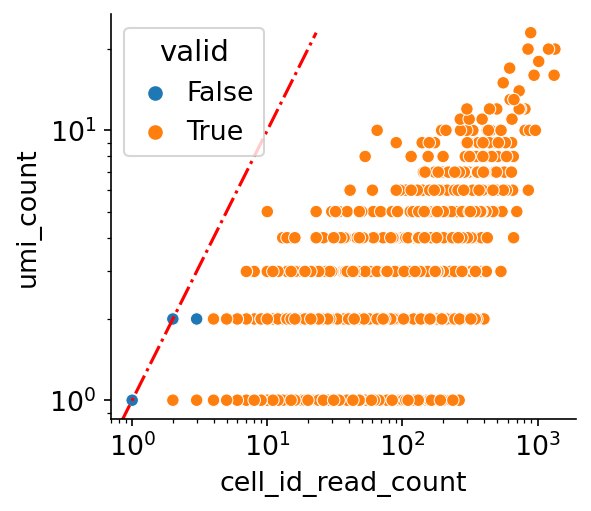

In [11]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=1.5,cell_key="cell_id",)

In [12]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
0,EB_FO864_RH_AAACCTGCAACGATCT,12,1,True
1,EB_FO864_RH_AAACCTGCAGACACTT,321,10,True
2,EB_FO864_RH_AAACCTGTCCAATGGT,223,4,True
3,EB_FO864_RH_AAACCTGTCGGCGCTA,38,1,True
4,EB_FO864_RH_AAACGGGGTAGCTTGT,97,2,True
...,...,...,...,...
1430,EB_FO864_RH_TTTGCGCGTATAAACG,8,1,True
1432,EB_FO864_RH_TTTGCGCGTGATGTGG,146,4,True
1433,EB_FO864_RH_TTTGGTTAGAAGGTGA,15,1,True
1434,EB_FO864_RH_TTTGGTTCAAGTTGTC,31,1,True


In [13]:
df = pd.DataFrame(df_valid_cells)
df.to_csv(output_dir+sample+'.csv', index=False)

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. 

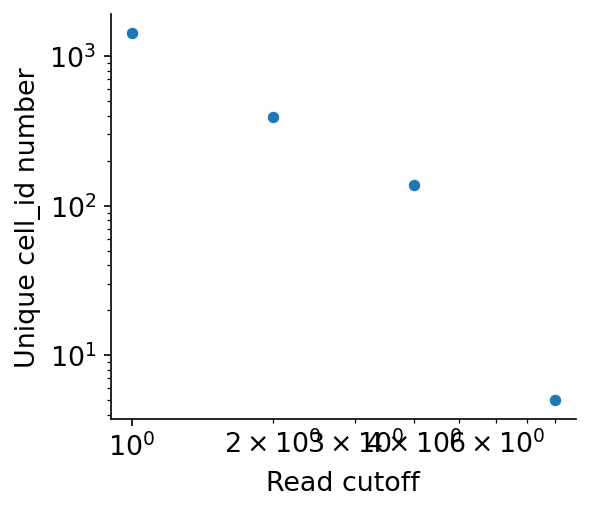

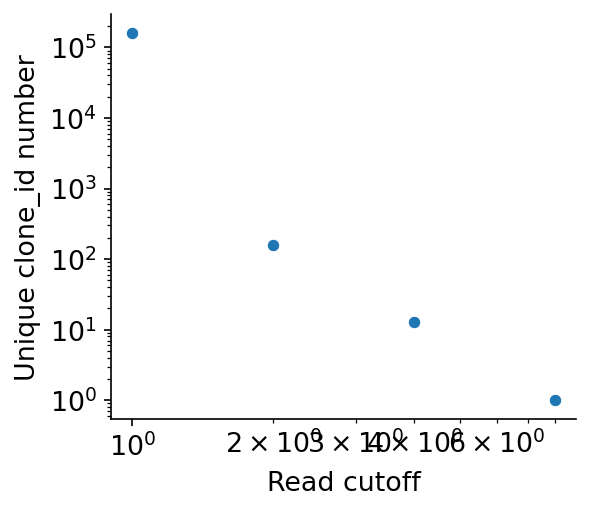

In [14]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [15]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 1436
clone_id number: 161527
umi_id number: 4136
total reads: 173K


## Collapse clone_id and filter cells within the same clone_id length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at coarse_grained_readcutoff_floor

In [16]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
read_cutoff=2 # initial read count filtering 
# coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells(df,coarse_grained_readcutoff=None):
    if coarse_grained_readcutoff is None:
        coarse_grained_readcutoff=np.max([coarse_grained_readcutoff_floor,0.01*df['read'].max()])
    return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]

df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        denoise_method="UMI_tools",  # UMI_tools, 'Hamming'
        distance_threshold=1, #np.max([1,int(target_length*distance_relative_threshold)]),      
        read_cutoff=read_cutoff,
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_out=df_HQ_group.groupby('clone_id',group_keys=True).apply(filter_low_read_cells).reset_index(drop=True)
    df_out['bc_length']=target_length
    df_list.append(df_out)
df_denoise_bc_1=pd.concat(df_list)

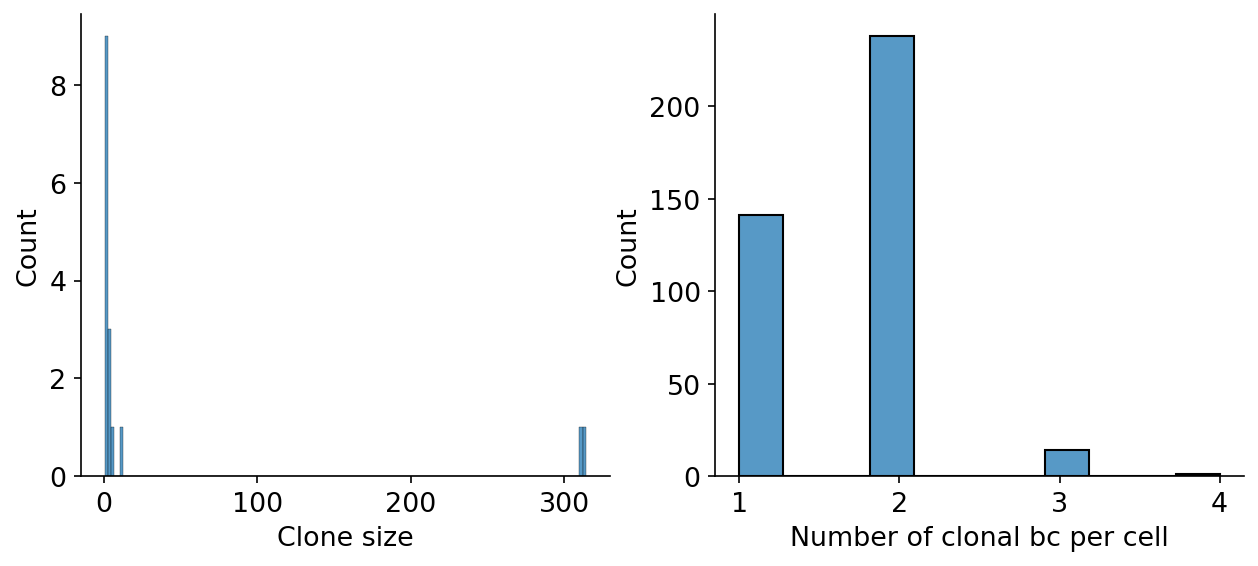

In [17]:
larry.QC_clonal_reports(df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

seq length


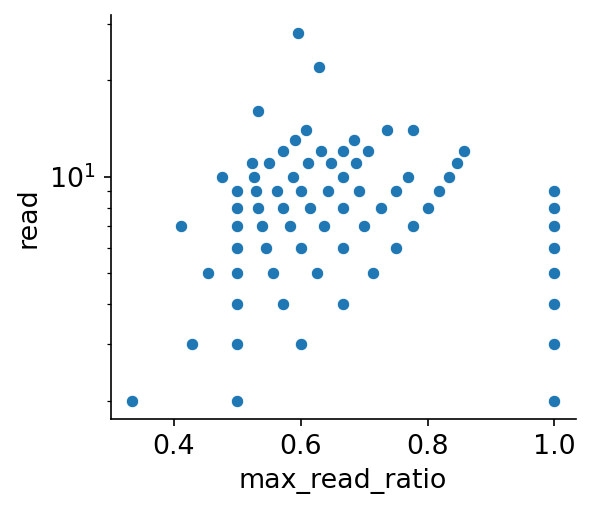

In [18]:
# select dominant barcode sequence within each cell barcode, we use a very high read_ratio to avoid false positive
#df_dominant_frac=car.calculate_read_fraction_for_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
df_dominant=larry.obtain_read_dominant_sequences(df_denoise_bc_1,cell_bc_key='cell_bc',clone_key='clone_id')
sns.scatterplot(data=df_dominant,x='max_read_ratio',y='read')
plt.yscale('log')